# Replication notebook for displacement book chapter

Sam Maurer, August 2017, Python 3.6

In [45]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import zipfile

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = 12, 8

In [87]:
# Load PUMS households table
z = zipfile.ZipFile('../data/csv_hca_2013_1yr.zip')
pums = pd.read_csv(z.open('ss13hca.csv'), low_memory=False)

In [88]:
print(len(pums))

153589


In [89]:
# Limit to Bay Area counties

pums = pums.loc[(pums.PUMA//100).isin([1,13,41,55,75,81,85,95,97])]
print(len(pums))

31068


In [5]:
# Load persons table
z = zipfile.ZipFile('../data/csv_pca_2013_1yr.zip')
persons = pd.read_csv(z.open('ss13pca.csv'), low_memory=False)

In [6]:
print(len(persons))

371403


In [7]:
# Keep householders and relevant colums
persons = persons.loc[persons.RELP.isin([0]), ['SERIALNO','AGEP']]
print(len(persons))

130145


In [8]:
# Merged with other table
pums = pd.merge(pums, persons, how='left', on='SERIALNO')
print(len(pums))

31068


In [13]:
# TEN = Tenure
# 1 - owned with mortgage loan
# 2 - owned free and clear
# 3 - rented
# 4 - occupied without payment of rent

print(pums.TEN.value_counts())

1.0    11974
3.0    10168
2.0     4847
4.0      351
Name: TEN, dtype: int64


In [14]:
# MV = When moved into this house or apartment
# 1 - 12 months or less

print(pums.MV.value_counts())

3.0    6602
4.0    5891
5.0    5627
7.0    3529
1.0    3392
6.0    3199
2.0    1851
Name: MV, dtype: int64


In [17]:
print(len(pums.loc[pums.MV.isin([1]) & pums.TEN.isin([3])]))  # recent movers who rent
print(len(pums.loc[pums.MV.isin([1]) & pums.TEN.isin([1,2])]))  # recent movers who own

2489
861


In [15]:
# Variables for regression

pums['moved'] = pums.MV.isin([1]).astype(int)
pums['renter'] = pums.TEN.isin([3]).astype(int)
pums['age'] = pums.AGEP
pums['income'] = pums.HINCP / 1000
pums['persons'] = pums.NP

print(pums.loc[:,['moved','renter','age','income','persons']].head())

   moved  renter   age  income  persons
0      0       0  45.0    16.0        2
1      0       1  64.0     9.4        2
2      0       0  73.0   193.5        2
3      0       0  44.0   224.0        4
4      0       1  32.0     8.4        4


In [34]:
results = sm.Logit.from_formula('moved ~ renter + income + age + persons - 1', pums).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.310687
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  moved   No. Observations:                27340
Model:                          Logit   Df Residuals:                    27336
Method:                           MLE   Df Model:                            3
Date:                Thu, 17 Aug 2017   Pseudo R-squ.:                  0.1714
Time:                        21:34:23   Log-Likelihood:                -8494.2
converged:                       True   LL-Null:                       -10251.
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
renter         1.2799      0.037     34.782      0.000       1.208       1.352
income         0.0008      0.

## Bar plot of rents by county

In [101]:
pums['rent'] = pums.RNTP
pums['CFIPS'] = pums.PUMA // 100  # 3 digits of county FIPS, 2 digits of PUMA id

print(pums.loc[:,['rent','CFIPS']].head())

     rent  CFIPS
2     NaN     85
9   770.0      1
21    NaN     85
25    NaN     55
28  750.0     13


In [36]:
pums.CFIPS.value_counts()

85    7348
1     6949
13    4019
75    3739
81    3031
97    2203
95    1809
41    1179
55     791
Name: CFIPS, dtype: int64

In [47]:
movers = pums.loc[pums.moved == 1]
movers_rent = movers.groupby('CFIPS').median().rent
print(movers_rent)

CFIPS
1     1400.0
13    1300.0
41    1600.0
55    1700.0
75    2000.0
81    1800.0
85    1700.0
95    1200.0
97    1300.0
Name: rent, dtype: float64


In [40]:
non_movers = pums.loc[pums.moved == 0]
non_movers_rent = non_movers.groupby('CFIPS').median().rent
print(non_movers_rent)

CFIPS
1     1200.0
13    1300.0
41    1500.0
55    1200.0
75    1400.0
81    1500.0
85    1500.0
95    1100.0
97    1200.0
Name: rent, dtype: float64


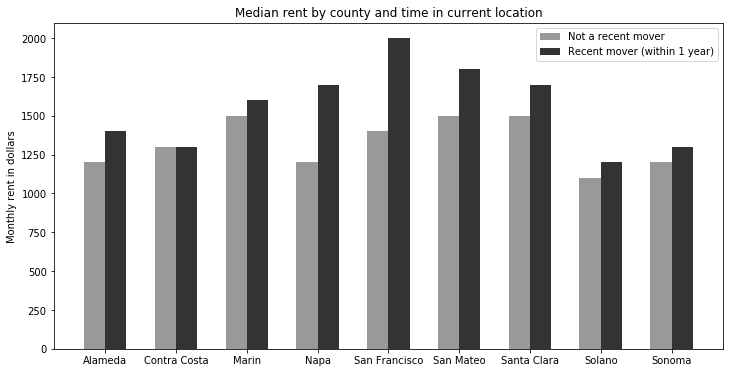

In [59]:
n = 9
ind = np.arange(n)
width = 0.3

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(ind, non_movers_rent, width, color=(0.6, 0.6, 0.6))
rects2 = ax.bar(ind+width, movers_rent, width, color=(0.2, 0.2, 0.2))

ax.set_ylabel('Monthly rent in dollars')
ax.set_title('Median rent by county and time in current location')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Alameda', 'Contra Costa', 'Marin', 'Napa', 'San Francisco', 'San Mateo',
                    'Santa Clara', 'Solano', 'Sonoma'))

ax.legend((rects1[0], rects2[0]), ('Not a recent mover', 'Recent mover (within 1 year)'))
plt.show()

In [60]:
fig.savefig('../output/figure-median-rent.pdf')

## Rent burden

In [90]:
pums['rent'] = pums.RNTP
pums['income'] = pums.HINCP
pums['moved'] = pums.MV.isin([1]).astype(int)

In [91]:
pums.loc[pums.income > 0, 'rent_burden'] = (pums.rent * 12) / pums.income

In [95]:
movers = pums.loc[(pums.rent > 0) & (pums.moved == 1)]
non_movers = pums.loc[(pums.rent > 0) & (pums.moved == 0)]

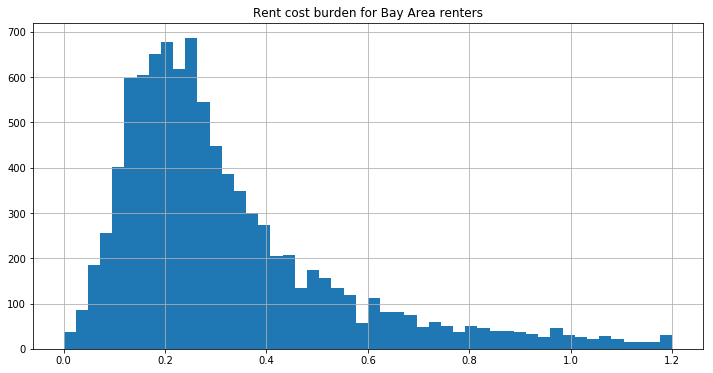

In [105]:
rent_burden.hist(range=(0,1.2), bins=50, figsize=(12,6))
plt.title('Rent cost burden for Bay Area renters')

/Users/maurer/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/maurer/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


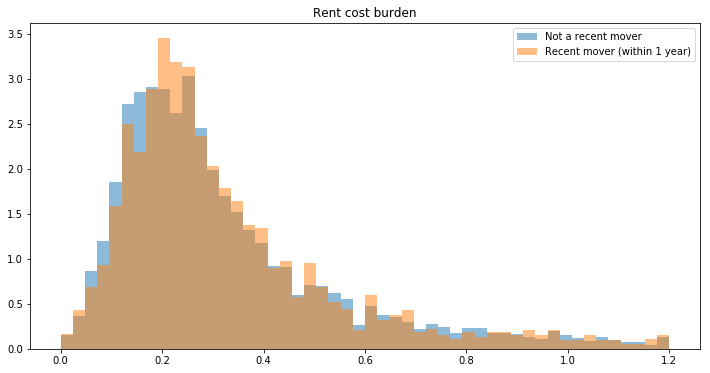

In [106]:
fig, ax = plt.subplots(figsize=(12,6))

ax.hist(non_movers.rent_burden, range=(0,1.2), bins=50, normed=True, alpha=0.5, label='Not a recent mover')
ax.hist(movers.rent_burden, range=(0,1.2), bins=50, normed=True, alpha=0.5, label='Recent mover (within 1 year)')

plt.title('Rent cost burden')
plt.legend()
plt.show()

In [102]:
sf_movers = pums.loc[(pums.CFIPS == 75) & (pums.rent > 0) & (pums.moved == 1)]
sf_non_movers = pums.loc[(pums.CFIPS == 75) & (pums.rent > 0) & (pums.moved == 0)]

/Users/maurer/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/maurer/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


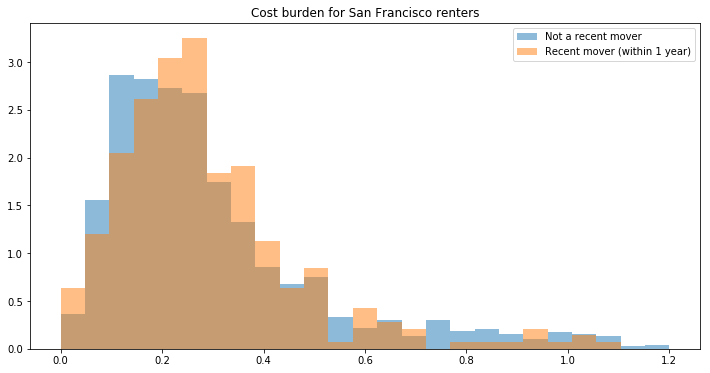

In [107]:
fig, ax = plt.subplots(figsize=(12,6))

ax.hist(sf_non_movers.rent_burden, range=(0,1.2), bins=25, normed=True, alpha=0.5, label='Not a recent mover')
ax.hist(sf_movers.rent_burden, range=(0,1.2), bins=25, normed=True, alpha=0.5, label='Recent mover (within 1 year)')

plt.title('Cost burden for San Francisco renters')
plt.legend()
plt.show()

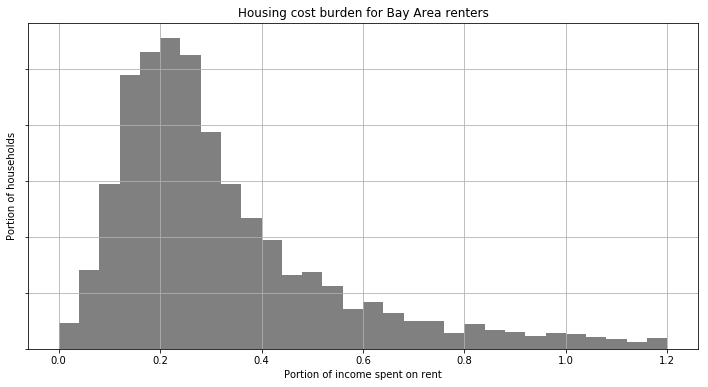

In [112]:
fig, ax = plt.subplots(figsize=(12,6))

pums.rent_burden.hist(range=(0,1.2), bins=30, color='grey')

plt.title('Housing cost burden for Bay Area renters')
ax.set_xlabel('Portion of income spent on rent')
ax.set_ylabel('Portion of households')
ax.set_yticklabels('')

plt.show()

In [113]:
fig.savefig('../output/figure-cost-burden.pdf')